### Notebook to analyse *.nc files (with single variables) 

In [1]:
#TODO: extend to multiple variables 

# Imports
import matplotlib.pyplot as plt
import numpy as np
import iris
from iris.analysis import Aggregator
import iris.plot as iplt
import iris.quickplot as qplt
from iris.util import rolling_window

from ruamel.yaml import ruamel

Utilizing 
https://scitools.org.uk/iris/docs/latest/examples/General/custom_aggregation.html


In [2]:
# check for CONSECUTIVLY REPEATED exceedance of threshholds:
#adjusted code example from https://scitools.org.uk/iris/docs/latest/examples/General/custom_aggregation.html


# Define a function to perform the custom statistical operation.
# Note: in order to meet the requirements of iris.analysis.Aggregator, it must
# do the calculation over an arbitrary (given) data axis.
def count_spells(data, threshold, axis, spell_length):
    """
    Function to calculate the number of points in a sequence where the value
    has exceeded a threshold value for at least a certain number of timepoints.

    Generalised to operate on multiple time sequences arranged on a specific
    axis of a multidimensional array.

    Args:

    * data (array):
        raw data to be compared with value threshold.

    * threshold (float):
        threshold point for 'significant' datapoints.

    * axis (int):
        number of the array dimension mapping the time sequences.
        (Can also be negative, e.g. '-1' means last dimension)

    * spell_length (int):
        number of consecutive times at which value > threshold to "count".

    """
    if axis < 0:
        # just cope with negative axis numbers
        axis += data.ndim
    # Threshold the data to find the 'significant' points.
    data_hits = data > threshold
    # Make an array with data values "windowed" along the time axis.
    hit_windows = rolling_window(data_hits, window=spell_length, axis=axis)
    # Find the windows "full of True-s" (along the added 'window axis').
    full_windows = np.all(hit_windows, axis=axis+1)
    # Count points fulfilling the condition (along the time axis).
    spell_point_counts = np.sum(full_windows, axis=axis, dtype=int)
    return spell_point_counts


# check for CUMULATIVE exceedance of threshhold:
#adjusted code example from https://scitools.org.uk/iris/docs/latest/examples/General/custom_aggregation.html


def count_accumulated_exceedance(data, threshold, axis, accumulation_length):
    """
    Function to calculate the number of points in a sequence where the cumulative value
    has exceeded a threshold within a certain number of timepoints (accumulation_length).

    Generalised to operate on multiple time sequences arranged on a specific
    axis of a multidimensional array.

    Args:

    * data (array):
        raw data to be compared with value threshold.

    * threshold (float):
        threshold point for accumulation over datapoints.

    * axis (int):
        number of the array dimension mapping the time sequences.
        (Can also be negative, e.g. '-1' means last dimension)

    * accumulation_length (int):
        number of timepoint for which the average shall be calculated.

    """
    if axis < 0:
        # just cope with negative axis numbers
        axis += data.ndim

    # Make an array with data values "windowed" along the time axis.
    accumulation_windows = rolling_window(data,window=accumulation_length, axis=axis)
    # Find the windows exceeding the accumulation threshold (along the added 'window axis').
    exceeding_windows = np.sum(accumulation_windows,axis=axis+1)>threshold
    # Count points fulfilling the condition (along the time axis).
    exceeding_count = np.sum(exceeding_windows, axis=axis, dtype=int)
    return exceeding_count
  



def load_data_from_netcdf (filepath):
    # Load the whole data (as a list of cubes)
    file_path = (filepath)
    data = iris.load(file_path)
    return data

def get_cube_from_cubelist (data, variablename):
    filtered_cubelist = data.extract(variablename)
    return filtered_cubelist[0]
    
def calculate_data_above_threshold_for_x_days(data, threshold, numberOfDays, relativeValue):
    
    # Make an aggregator from the user function.
    SPELL_COUNT = Aggregator('spell_count',
                             count_spells,
                             units_func=lambda units: 1)

    # Calculate the statistic
    data_above_threshold = data.collapsed('time', SPELL_COUNT,
                                  threshold=threshold,
                                  spell_length=numberOfDays)
    # TODO: customize label
    data_above_threshold.rename(' Percentage of days with consecutive '+str(numberOfDays)+'-day snow falls above '+str(threshold)+'mm in timeperiod')
    
    
    # relative result
    if(relativeValue==True):
        total_days = data.coords("time")[0].shape[0]
        data_above_threshold.data = data_above_threshold.data/numberOfDays*100
        data_above_threshold.rename(' Percentage of days with consecutive '+str(numberOfDays)+'-day snow falls above '+str(threshold)+'mm in timeperiod')
    else:
          data_above_threshold.rename(' Number of days with '+str(numberOfDays)+'-day snow falls above '+str(threshold)+'mm for each day in timeperiod')
    
    return data_above_threshold
    

def calculate_data_above_threshold_in_x_days(data, threshold, numberOfDays, relativeValue):
    
    # Make an aggregator from the user function.
    ACCUMULATION_COUNT = Aggregator('accumulation_exceedance_count',
                             count_accumulated_exceedance,
                             units_func=lambda units: 1)

    # Calculate the statistic
    data_above_threshold = data.collapsed('time', ACCUMULATION_COUNT,
                                  threshold=threshold,
                                  accumulation_length=numberOfDays)
  
    
    
    
    
    # relative result
    if(relativeValue==True):
        data_above_threshold.rename(' Percentage of days with accumulated snow  falls in ' +str(numberOfDays) +' days above '+str(threshold)+'mm')
        total_days = data.coords("time")[0].shape[0]
        data_above_threshold.data = data_above_threshold.data/numberOfDays*100
    else:
        data_above_threshold.rename(' Number of days with accumulated snow falls in ' +str(numberOfDays) +' days above '+str(threshold)+'mm')
    return data_above_threshold



####  Analysis functions

In [3]:
def data_analysis(filepath, depth_thresholds,time_thresholds):
    # retrieve data
    data = load_data_from_netcdf(filepath)
    cube_daily = get_cube_from_cubelist(data)
    # change and accumulation analysis to be included later, cube_change = get_cube_from_cubelist(data,'approx_change_snow_height')
    datalist = []
    datalist.append(cube_daily)
    threshholded_data = {}
    # loop over thresholds, calculate and plot results
   
    for i_data in datalist:
        for i_time in time_thresholds:
            for i_depth in depth_thresholds:
                threshholded_data[i_data, i_depth, i_time] = calculate_data_above_threshold_in_x_days(i_data,i_depth,i_time, False)
                
    return threshholded_data # returns dictionary of data indexed by datasource and threshhold values



In [4]:
# multi-model data analysis, filepaths to be submitted as yml

def multi_model_analysis (filepathsfile, depth_thresholds, time_thresholds):
    # load filelist
    yaml = ruamel.yaml.YAML()
    with open(filepathsfile, 'r') as stream:
        try:
            filepaths = yaml.load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    multi_model_data = {}
    for i_filepath in filepaths:
        print("Analysing data from "+str(i_filepath))
        multi_model_data [i_filepath] = data_analysis(i_filepath, depth_thresholds,time_thresholds)
    return multi_model_data

In [ ]:

# multi-model data analysis, filepaths to be submitted as yml, filter to be submitted as list of string or similar iterable object

def multi_model_analysi_filtered (filepathsfile, depth_thresholds, time_thresholds, model_name_filter):
    # load filelist
    yaml = ruamel.yaml.YAML()
    with open(filepathsfile, 'r') as stream:
        try:
            filepaths = yaml.load(stream)
        except yaml.YAMLError as exc:
            print(exc)
       
    
    filecache = []
    for i_filter in model_name_filter:
        for filename in filepaths.rglob((i_filter  + "*.nc")):
            if filepaths.rglob((i_filter + "*.nc")):
                filecache.append(str(filename))
    filepaths_filtered = filecache
    multi_model_data = {}
    for i_filepath in filepaths_filtered:
        print("Analysing data from "+str(i_filepath))
        multi_model_data [i_filepath] = data_analysis(i_filepath, depth_thresholds,time_thresholds)
    return multi_model_data


#### Some initial data probing

In [2]:
# test for multi model execution

multi_model_file = '/home/quante/projects/extremesnowevents/multi_model_output_test.yml'

print(multi_model_file)

/home/quante/projects/extremesnowevents/multi_model_output_test.yml


#### Some Plots

In [3]:
# def plot function

def contour_plot_intensity_data (data,contour_levels,filename = ''):  
    # Plot the results.
    qplt.contourf(data,contour_levels,cmap='GnBu')
    plt.gca().coastlines()

    plt.savefig(filename)
    iplt.show()
def contour_plot_compare_intensity_data (data,contour_levels, filename = ''):  
    # Plot the results.
    qplt.contourf(data,contour_levels,cmap='coolwarm')
    plt.gca().coastlines()
   
    plt.savefig(filename)
    iplt.show() 
    

In [20]:
# some first primitive code to analyse differences between ssp585 and 126:
keys = multi_model_data.keys()

key1 = list(keys)[0]
key2 = list(keys)[1]

keys1_1 = multi_model_data[key1].keys()
keys2_1 = multi_model_data[key2].keys()
key1_1 = list(keys1_1)[8]
key2_1 = list(keys2_1)[8]

ssp126 = multi_model_data[key1]
ssp585 = multi_model_data[key2]

ssp126_example = ssp126[key1_1]
ssp585_example = ssp585[key2_1]

print(ssp126_example)
print(ssp585_example)

test = ssp585_example-ssp126_example

print (key1_1)
print(key2_1)

test.rename('MPI_2095_2099_Diff_SSP585-SSP126')  
print(test)
iris.save(test, 'MPI_2095_2099_Diff_SSP126_585.nc')



 Number of days with accumulated snow falls in 2 days above 250mm / (1) (latitude: 192; longitude: 384)
     Dimension coordinates:
          latitude                                                               x               -
          longitude                                                              -               x
     Scalar coordinates:
          time: 2097-07-02 00:00:00, bound=(2095-01-01 12:00:00, 2099-12-31 12:00:00)
     Attributes:
          citation: https://doi.org/10.5281/zenodo.1241051
          contact: sven.willner@pik-potsdam.de
          created_at: 2020-02-12 11:54:13
          created_with: https://github.com/swillner/flood-processing by S. Willner
     Cell methods:
          accumulation_exceedance_count: time
 Number of days with accumulated snow falls in 2 days above 250mm / (1) (latitude: 192; longitude: 384)
     Dimension coordinates:
          latitude                                                               x               -
          longi

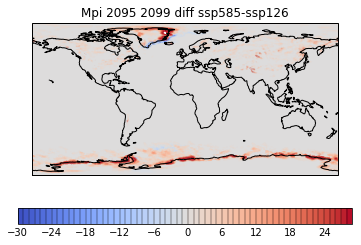

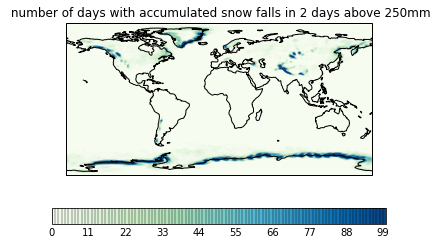

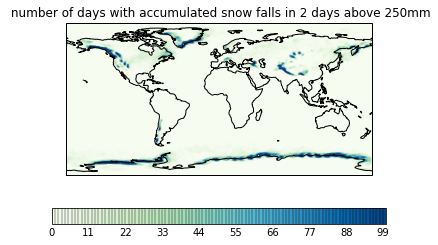

In [52]:
#plot difference data
contour_levels_compare = np.arange(-30,30,1)


# 'MPI_2095-2099_Diff_SSP585-126.png' 'MPI_2095-2099_SPP585.png' 'MPI_2095-2099_SPP126.png'

contour_plot_compare_intensity_data(test,contour_levels_compare, filename = 'MPI_2095-2099_Diff_SSP585-126.svg')

# plot base data

contour_levels_intensity = np.arange(0,101,1)
contour_plot_intensity_data(ssp585_example,contour_levels_intensity, filename = 'MPI_2095-2099_SPP585.svg')
contour_plot_intensity_data(ssp126_example,contour_levels_intensity, filename = 'MPI_2095-2099_SPP126.svg')